# Heart Disease Classification Analysis

## Team Members
- Omar Baher Hussein 21P0315
- Saifeldin Mohamed Yousry 21P0362
- Mohamed Ehab Badr 21P0375
- Mohamed Khaled ElHelaly 21P0185
- Abdallah Ahmed Hamdy 21P0333
- Ahmed Hossam ElDin 21P0271

## Introduction
This notebook explores heart disease classification using three different classification ML algorithms:
1. Decision Tree Classifier
2. Naive Bayes Classifier
3. K-Nearest Neighbors (KNN) Classifier

We'll go through the following steps:
- Necessary Data Preprocessing
- Some Data Visualization
- Outlier Removal
- Feature Scaling
- Model Training and Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    precision_score, 
    recall_score, 
    f1_score
)

np.random.seed(42)
plt.style.use('seaborn')

## Data Loading and Initial Exploration

In [2]:
df = pd.read_csv('./Dataset/heart.csv')

# Display basic info
print(df.info())
print('\nTarget Distribution:')
print(df['target'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None

Target Distribution:
target
1    0.544554
0    0.455446
Name: proportion, dtype: float64


## Data Visualization
#### Target Variable Distribution

Text(0.5, 1.0, 'Heart Disease Distribution')

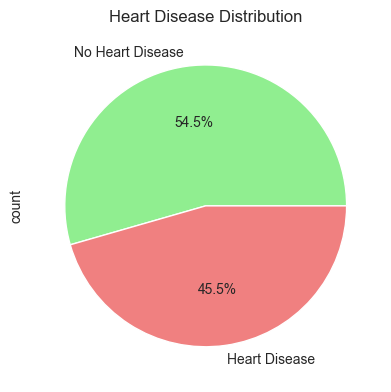

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['target'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                 labels=['No Heart Disease', 'Heart Disease'],
                                 colors=['lightgreen', 'lightcoral'])
plt.title('Heart Disease Distribution')

#### Correlation Heatmap

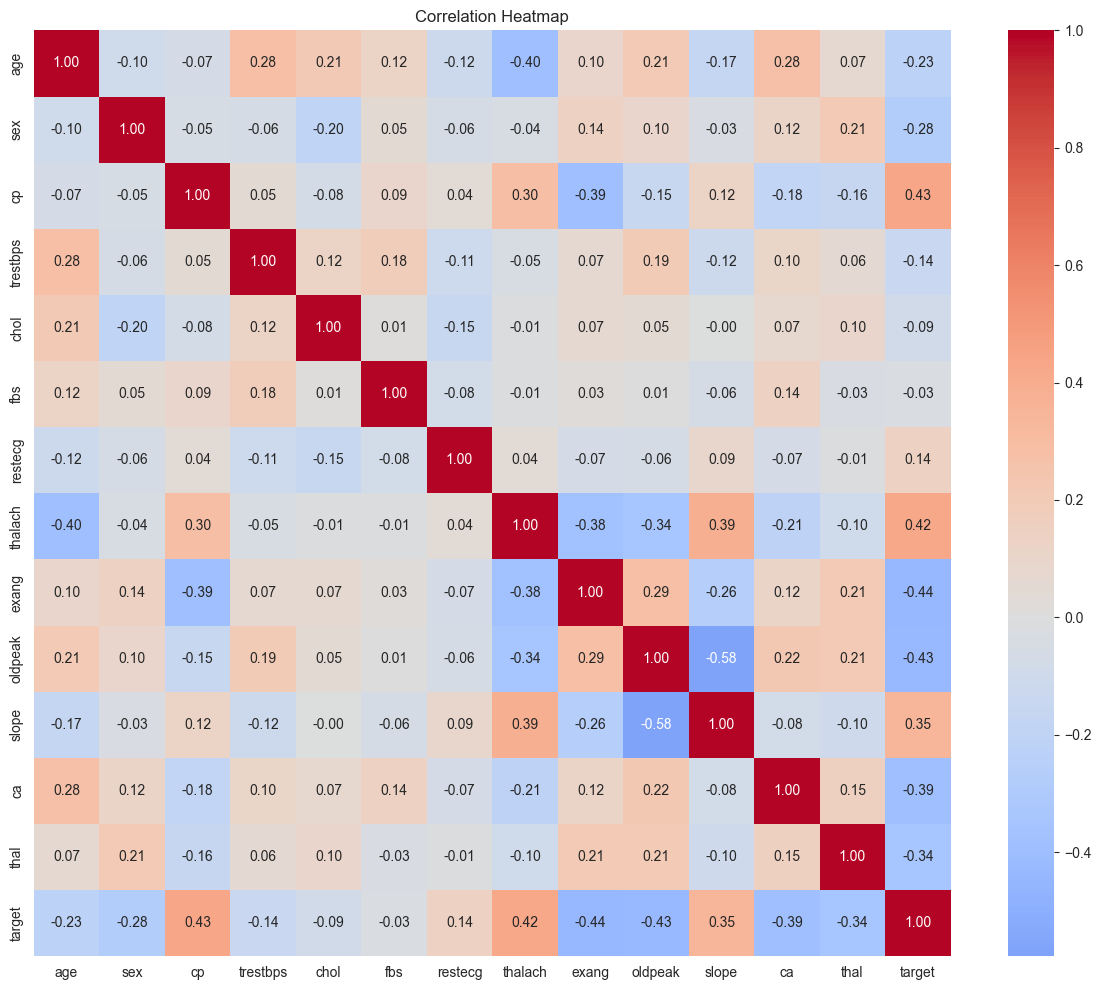

In [15]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [16]:
print("\nTop Correlations with Heart Disease:")
print(correlation_matrix['target'].sort_values(ascending=False))


Top Correlations with Heart Disease:
target      1.000000
cp          0.433798
thalach     0.421741
slope       0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex        -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang      -0.436757
Name: target, dtype: float64


#### Detailed Feature Distributions

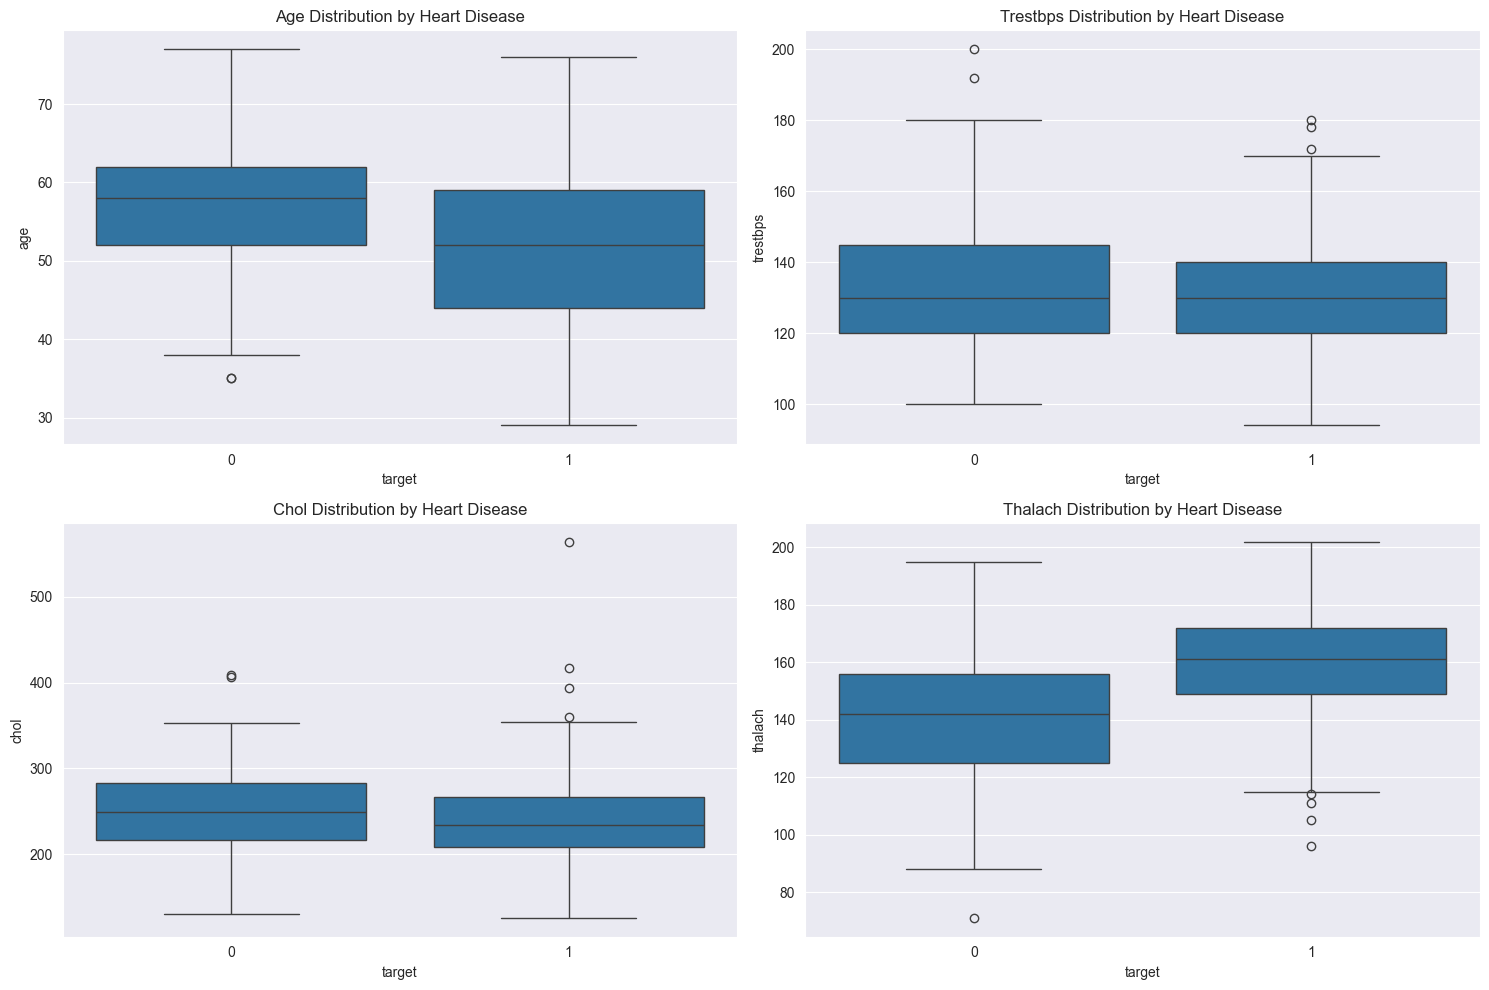

In [17]:
features = ['age', 'trestbps', 'chol', 'thalach']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='target', y=feature, data=df)
    plt.title(f'{feature.capitalize()} Distribution by Heart Disease')

plt.tight_layout()
plt.show()

#### Age vs Cholesterol & Age vs Max Heart Rate & Chest Pain Types

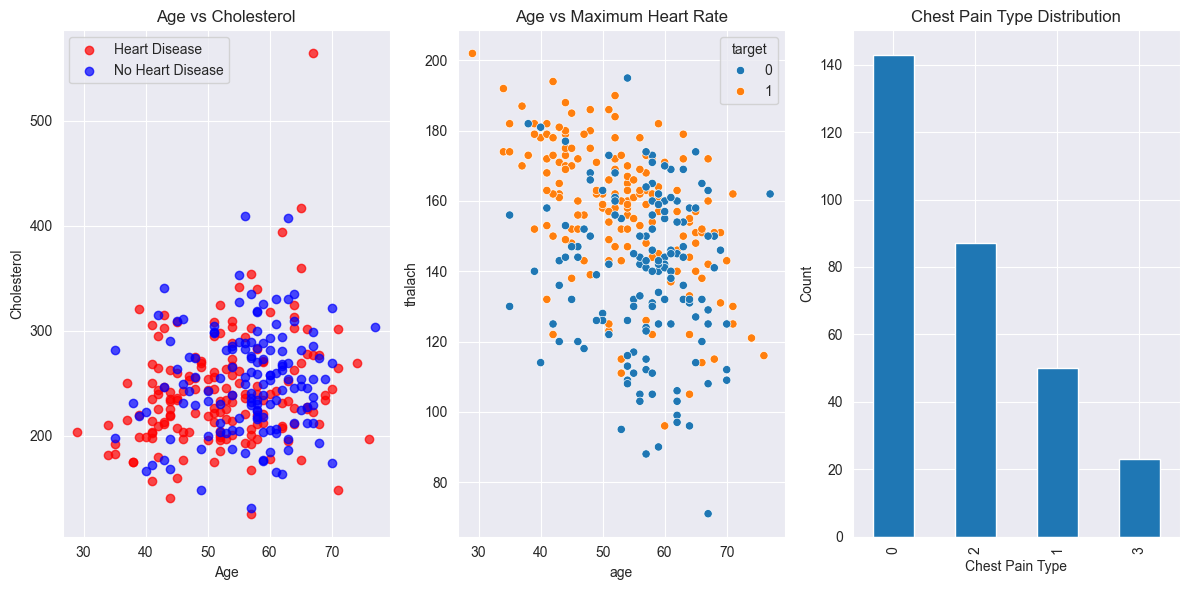

In [26]:
plt.figure(figsize=(12, 6))
# Age vs Cholesterol
plt.subplot(1, 3, 1)
plt.scatter(df[df['target']==1]['age'], df[df['target']==1]['chol'],
            label='Heart Disease', alpha=0.7, color='red')
plt.scatter(df[df['target']==0]['age'], df[df['target']==0]['chol'],
            label='No Heart Disease', alpha=0.7, color='blue')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.title('Age vs Cholesterol')
plt.legend()

# Age vs Max Heart Rate
plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x='age', y='thalach', hue='target')
plt.title('Age vs Maximum Heart Rate')

# Chest Pain Types
plt.subplot(1, 3, 3)
df['cp'].value_counts().plot(kind='bar')
plt.title('Chest Pain Type Distribution')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Outlier Detection and Removal

We'll use the Interquartile Range (IQR) method to detect and remove outliers:

In [5]:
def remove_outliers(df):
    df_clean = df.copy()

    # DF Numeric columns
    numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

    # Remove outliers from each numeric column
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean = df_clean[(df_clean[col] >= lower_bound) &
                            (df_clean[col] <= upper_bound)]

    return df_clean


df_clean = remove_outliers(df)

print(f'Original dataset size: {len(df)}')
print(f'Clean dataset size: {len(df_clean)}')
print(f'Removed rows: {len(df) - len(df_clean)}')

Original dataset size: 303
Clean dataset size: 280
Removed rows: 23


## Data Preparation

Separate features and target, and perform train-test split:

In [6]:
X = df_clean.drop('target', axis=1)
y = df_clean['target']

# Split the data randomly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training and Evaluation Functions

In [7]:
def evaluate_model(y_true, y_pred, model_name):
    print(f'-.- {model_name} Performance Metrics -.-')
    print('Accuracy Score:', accuracy_score(y_true, y_pred))
    print('Precision Score:', precision_score(y_true, y_pred))
    print('Recall Score:', recall_score(y_true, y_pred))
    print('F1 Score:', f1_score(y_true, y_pred))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_true, y_pred))
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred))

def plot_confusion_matrix(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Disease', 'Disease'], 
                yticklabels=['No Disease', 'Disease'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

## 1. Decision Tree Classifier

--- Decision Tree Performance Metrics ---
Accuracy Score: 0.7142857142857143
Precision Score: 0.7058823529411765
Recall Score: 0.8
F1 Score: 0.75

Confusion Matrix:
[[16 10]
 [ 6 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        26
           1       0.71      0.80      0.75        30

    accuracy                           0.71        56
   macro avg       0.72      0.71      0.71        56
weighted avg       0.72      0.71      0.71        56



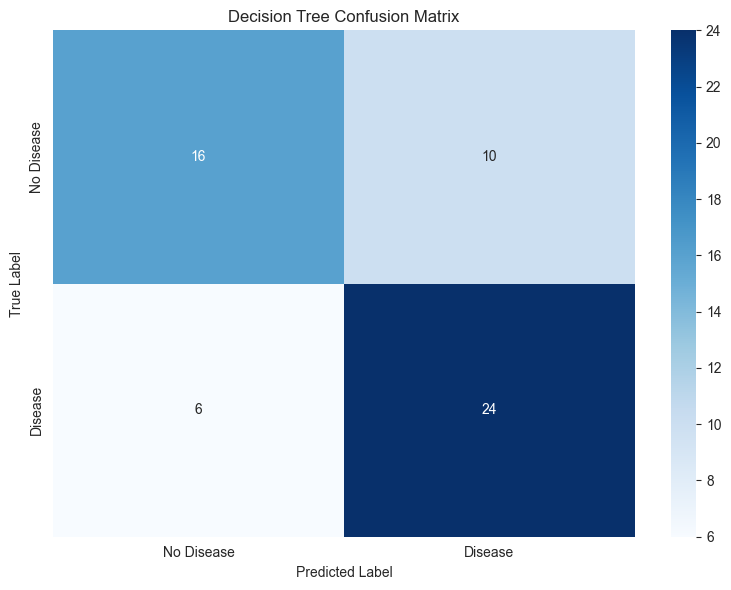

In [8]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_scaled, y_train)

dt_pred = dt_classifier.predict(X_test_scaled)

# Evaluate Model
evaluate_model(y_test, dt_pred, 'Decision Tree')
plot_confusion_matrix(y_test, dt_pred, 'Decision Tree')

## 2. Naive Bayes Classifier

--- Naive Bayes Performance Metrics ---
Accuracy Score: 0.8035714285714286
Precision Score: 0.7878787878787878
Recall Score: 0.8666666666666667
F1 Score: 0.8253968253968254

Confusion Matrix:
[[19  7]
 [ 4 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78        26
           1       0.79      0.87      0.83        30

    accuracy                           0.80        56
   macro avg       0.81      0.80      0.80        56
weighted avg       0.81      0.80      0.80        56



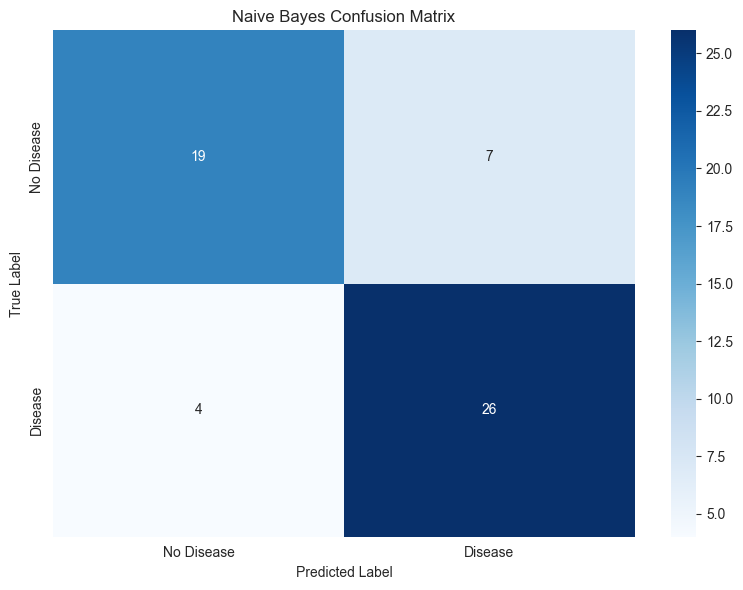

In [9]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_scaled, y_train)

nb_pred = nb_classifier.predict(X_test_scaled)

# Evaluate Model
evaluate_model(y_test, nb_pred, 'Naive Bayes')
plot_confusion_matrix(y_test, nb_pred, 'Naive Bayes')

## 3. K-Nearest Neighbors (KNN) Classifier with Hyperparameter
- Hyperparameter tuning is the practice of identifying and selecting the optimal hyperparameters for use in training a machine learning model.
- a hyperparameter is a parameter that can be set in order to define any configurable part of a model's learning process.

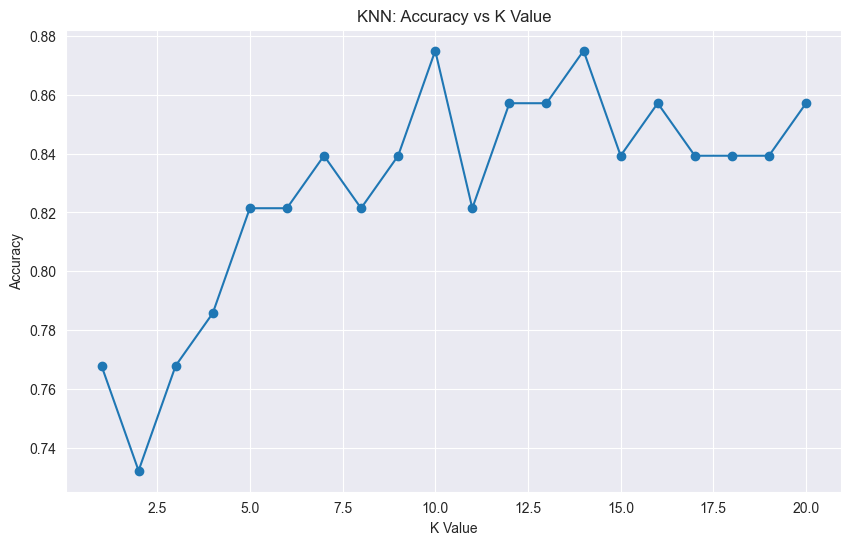

Best K Value: 10
--- K-Nearest Neighbors Performance Metrics ---
Accuracy Score: 0.875
Precision Score: 0.8285714285714286
Recall Score: 0.9666666666666667
F1 Score: 0.8923076923076924

Confusion Matrix:
[[20  6]
 [ 1 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85        26
           1       0.83      0.97      0.89        30

    accuracy                           0.88        56
   macro avg       0.89      0.87      0.87        56
weighted avg       0.89      0.88      0.87        56



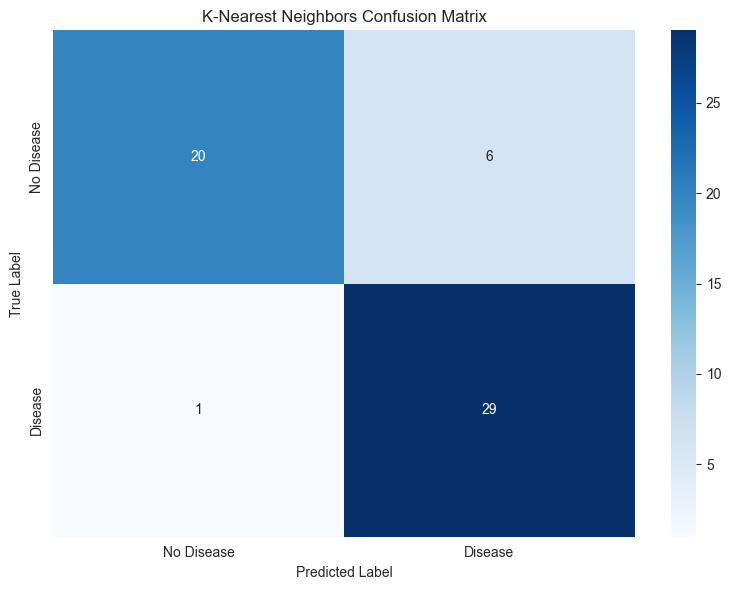

In [27]:
# KNN with Hyperparameter Tuning
knn_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    knn_scores.append(knn.score(X_test_scaled, y_test))

# Plot K values vs Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), knn_scores, marker='o')
plt.title('KNN: Accuracy vs K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.show()

# Best K value
best_k = knn_scores.index(max(knn_scores)) + 1
print(f'Best K Value: {best_k}')

# KNN with Best K
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(X_train_scaled, y_train)

# Predictions
knn_pred = knn_classifier.predict(X_test_scaled)

# Evaluate KNN
evaluate_model(y_test, knn_pred, 'K-Nearest Neighbors')
plot_confusion_matrix(y_test, knn_pred, 'K-Nearest Neighbors')

## Model Comparison

Create a summary of model performances:

In [11]:
# Create a performance comparison dataframe
performance_metrics = pd.DataFrame({
    'Model': ['Decision Tree', 'Naive Bayes', 'K-Nearest Neighbors'],
    'Accuracy': [
        accuracy_score(y_test, dt_pred),
        accuracy_score(y_test, nb_pred),
        accuracy_score(y_test, knn_pred)
    ],
    'Precision': [
        precision_score(y_test, dt_pred),
        precision_score(y_test, nb_pred),
        precision_score(y_test, knn_pred)
    ],
    'Recall': [
        recall_score(y_test, dt_pred),
        recall_score(y_test, nb_pred),
        recall_score(y_test, knn_pred)
    ],
    'F1 Score': [
        f1_score(y_test, dt_pred),
        f1_score(y_test, nb_pred),
        f1_score(y_test, knn_pred)
    ]
})

print(performance_metrics)

                 Model  Accuracy  Precision    Recall  F1 Score
0        Decision Tree  0.714286   0.705882  0.800000  0.750000
1          Naive Bayes  0.803571   0.787879  0.866667  0.825397
2  K-Nearest Neighbors  0.875000   0.828571  0.966667  0.892308


### Observations:
- Accuracy: KNN achieves the highest accuracy at 87.5%, which is significantly better than the Decision Tree model at 71.4% and Naive Bayes at 80.4%.
- Precision: KNN has a precision of 82.9%, the highest among the three models, indicating that it has the lowest rate of false positives.
- Recall: KNN excels with an impressive recall rate of 96.7%, meaning it correctly identifies the largest proportion of actual positive cases.
- F1 Score: KNN also has the highest F1 score at 89.2%, which represents a balanced measure of precision and recall. This suggests that the model demonstrates the best overall performance.

### Considerations:
- F1 Score is often the most reliable metric for imbalanced datasets because it balances precision and recall.
- Hyperparameter tuning for KNN likely contributed to its superior performance, making it better optimized than the other models

##### The K-Nearest Neighbors (KNN) model, enhanced through hyperparameter tuning, is the best-performing model based on all key metrics: accuracy, precision, recall, and F1 score.